**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import scipy
from scipy.spatial.distance import pdist, squareform, cdist
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances
import sklearn

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator): 
    
    def __init__(self, n_neighbors=1, algorithm='brute', metric='euclidean'):
        self.metric = metric
        self.k = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.dataset = X
        self.answers = y
        self.types = np.unique(y).shape[0]
        return self
    
    def brute(self, x):
        
        if type(x) == scipy.sparse.csr.csr_matrix:
            
            dist = pairwise_distances(x, self.dataset, metric=self.metric)
            
            indices = np.argpartition(dist, self.k, axis=1)[:, :self.k]
            
            return np.apply_along_axis(np.bincount, 1, self.answers[indices], minlength=self.types).argmax(axis=1)
        
        
        dist = cdist(x[np.newaxis], self.dataset, metric=self.metric)[0]
        indices = np.argpartition(dist, self.k + 1, 0)[:self.k]
        answers = self.answers[indices]
        prediction = np.argmax(np.bincount(answers, minlength=self.k))
        return prediction
        
    def kd_tree(self, x):
        tree = KDTree(self.dataset)
        indices = tree.query(x[np.newaxis], self.k, return_distance=False)
        answers = self.answers[indices.ravel()]
        prediction = np.argmax(np.bincount(answers, minlength=self.k))
        return prediction
    
    def predict_proba(self, x):
        
        if self.algorithm == 'kd_tree':
            return self.kd_tree(x)
        
        return self.brute(x)
    
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            return np.apply_along_axis(self.predict_proba, 1, X)
        elif self.algorithm == 'brute':
            if type(X) == scipy.sparse.csr.csr_matrix:
                return self.brute(X)
            return np.apply_along_axis(self.predict_proba, 1, X)
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=None)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
sklearn_pred, my_clf_pred

(array([2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2]),
 array([2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2], dtype=int64))

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

Wall time: 4 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

Wall time: 4 ms


c:\program files\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=None)

In [11]:
%time clf.predict(X_test)

Wall time: 4 ms


array([2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2])

In [14]:
%time my_clf.predict(X_test)

Wall time: 4 ms


array([2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [15]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [17]:
%time clf.fit(X_train, y_train)

Wall time: 4.09 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [18]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


c:\program files\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean',
                       n_neighbors=None)

In [21]:
%time clf.predict(X_test)

Wall time: 4.11 ms


array([0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 1, 0, 1, 1])

In [22]:
%time my_clf.predict(X_test)

Wall time: 4 ms


array([0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 1, 0, 1, 1], dtype=int64)

In [23]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [24]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [25]:
data = newsgroups['data']
target = newsgroups['target']

In [26]:
import re
def clear_data(data, target = []):
    data = [re.sub('[\W]', ' ', data[i]) for i in range(len(data))]
    data = [re.sub(' [a-z]{1,2} ', ' ', data[i].lower()) for i in range(len(data))]

    d = []
    y = []
    if not len(target):
        
    for i in range(len(data)):
        if len(data[i].split()):
            d.append(data[i])
            y.append(target[i])
    return d, y

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [27]:
vectorizer = sklearn.feature_extraction.text.CountVectorizer()

d, y = clear_data(data, target)
X = vectorizer.fit_transform(d)
y = np.asarray(y)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [29]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
sc = 0
for train_index, test_index in skf.split(X, y):
    clf = MyKNeighborsClassifier(n_neighbors=3)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))


        
    

0.1845692475463468
0.1935659760087241
0.1946564885496183


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [30]:
def get_scores_of_k(X, y, k, splits=3, metric='euclidean'):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    score = np.zeros(splits)
    i = 0
    for train_index, test_index in skf.split(X, y):
        clf = MyKNeighborsClassifier(n_neighbors=k, metric=metric)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score[i] = clf.score(X_test, y_test)
        i += 1
    return score

In [31]:
def get_score_rating(X, y, metric='euclidean'):
    scores = [get_scores_of_k(X, y, i + 1) for i in range(10)]
    mean_scores = np.mean(scores, axis = 1)
    scores_sorted = np.argsort(mean_scores)[::-1] + 1
    return mean_scores, scores_sorted

## countvectorizer euclidean

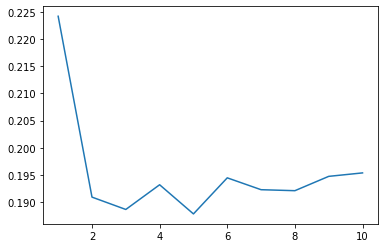

In [32]:
mean_scores, scores_sorted = get_score_rating(X, y)
neigbors = np.arange(1, 11)
axis = plt.plot(neigbors, mean_scores)

In [33]:
scores_sorted, np.sort(mean_scores)[::-1]

(array([ 1, 10,  9,  6,  4,  7,  8,  2,  3,  5], dtype=int64),
 array([0.2241912 , 0.1953835 , 0.19474736, 0.19447474, 0.19320247,
        0.19229371, 0.19211196, 0.19093057, 0.18865867, 0.18784079]))

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

## count_vectorizer, cosine

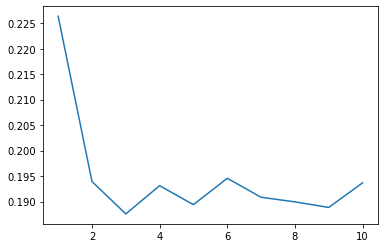

In [36]:
mean_scores_cosine, scores_sorted_cosine = get_score_rating(X, y, metric='cosine')
axis = plt.plot(neigbors, mean_scores_cosine)

In [37]:
scores_sorted_cosine, np.sort(mean_scores_cosine)[::-1]

(array([ 1,  6,  2, 10,  4,  7,  8,  5,  9,  3], dtype=int64),
 array([0.22637223, 0.19456561, 0.19392948, 0.19365685, 0.1931116 ,
        0.19083969, 0.18993093, 0.18938568, 0.18884042, 0.18756816]))

Для count_vectorizer особо изменений не видно 

## tfidf euclidean

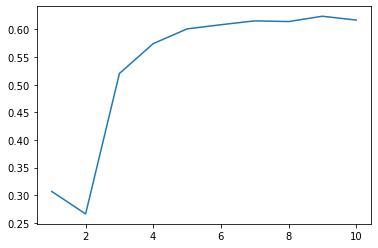

In [38]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(d)
y = np.asarray(y)

mean_scores_tfidf, scores_sorted_tfidf = get_score_rating(X_tfidf, y)
axis = plt.plot(neigbors, mean_scores_tfidf)

In [39]:
scores_sorted_tfidf, np.sort(mean_scores_tfidf)[::-1]

(array([ 9, 10,  7,  8,  6,  5,  4,  3,  1,  2], dtype=int64),
 array([0.62395493, 0.61704835, 0.61559433, 0.61432206, 0.60859687,
        0.60105416, 0.57442748, 0.52035623, 0.30679753, 0.26617594]))

При использовании tfidf сразу заметно, что точность для одного соседа - не самая большая. Виден рост при увеличении количества соседей

## tfidf cosine 

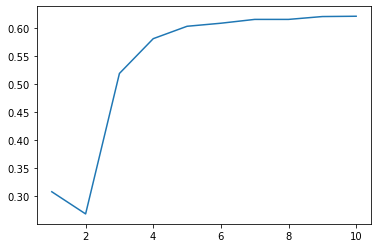

In [40]:
mean_scores_tfidf_cosine, scores_sorted_tfidf_cosine = get_score_rating(X_tfidf, y, 'cosine')
axis = plt.plot(neigbors, mean_scores_tfidf_cosine)

In [41]:
scores_sorted_tfidf_cosine, np.sort(mean_scores_tfidf_cosine)[::-1]

(array([10,  9,  8,  7,  6,  5,  4,  3,  1,  2], dtype=int64),
 array([0.62122864, 0.62068339, 0.61559433, 0.61559433, 0.60877863,
        0.60332606, 0.58124318, 0.51917485, 0.30816067, 0.26862959]))

Для косинусной метрики значения точности чуть-чуть больше

# Лучший результат показала модель с фичами, полученными через tfidf и количеством соседей - 8

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [42]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()


newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
data = newsgroups['data']
target = newsgroups['target']
d, y = clear_data(data, target)

X_tfidf = vectorizer.fit_transform(d)
y = np.asarray(y)

In [43]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [44]:
d, y_test = clear_data(newsgroups['data'], newsgroups['target'])
X_test = vectorizer.transform(d)
y_test = np.asarray(y_test)

In [45]:
k = 8
metric = 'cosine'
clf = MyKNeighborsClassifier(k, metric=metric)
clf.fit(X_tfidf, y)
clf.score(X_test, y_test)

0.5669722260227117

Значение точности на тесте на 6% ниже, чем значение на кросс-валидации. Вероятно, это связано с тем, что в тестовой выборке существуют примеры, не имеющие ничего общего с примерами из обучающей выборки. Модель немного переобучилась на трейне, и, соответственно, на тесте выдала не такой хороший результат, но всё равно неплохой.